In [2]:
!pip install gymnasium
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 7.4 MB/s eta 0:00:00


In [4]:
#!pip install --upgrade ptan torch
import torch
import torch.nn as nn
import copy
from collections import deque
from tqdm import tqdm

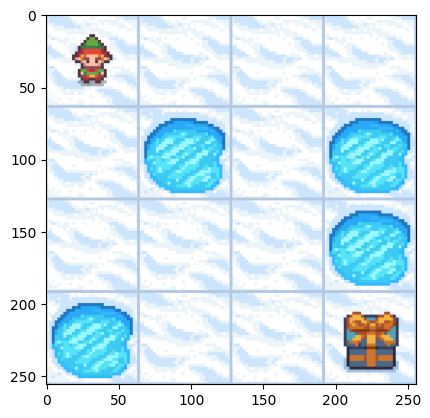

In [5]:
env=gym.make('FrozenLake-v1',render_mode='rgb_array')
env.reset()
plt.imshow(env.render())

In [6]:
n_s=env.observation_space.n
n_a=env.action_space.n
n_epi=5000
disc=.95
eps=1 #eps-=(1/n_epi)

In [7]:
def get_in(s_bat,n_s=n_s):
  s_oh=[]
  for s in s_bat:
    oh=np.zeros(n_s)
    oh[s]=1
    s_oh.append(oh)
  return torch.Tensor(s_oh)

In [8]:
def pi_eps(model,s,eps):
  u=random.random()
  if u>=eps:
    a=np.argmax(model(get_in([s])).data.numpy())
  else:
    a=env.action_space.sample()
  return a

In [9]:
def get_bat(replay,n_bat):
  bat=random.sample(replay,n_bat)
  s_bat=[s for (s,a,r,s1,d) in bat]
  a_bat=torch.Tensor([a for (s,a,r,s1,d) in bat]).long()
  r_bat=torch.Tensor([r for (s,a,r,s1,d) in bat])
  s1_bat=[s1 for (s,a,r,s1,d) in bat]
  done_bat=torch.Tensor([d for (s,a,r,s1,d) in bat])
  return s_bat,a_bat,r_bat,s1_bat,done_bat

In [10]:
n_buf=10000
n_bat=200

In [11]:
replay=deque(maxlen=n_buf)

In [12]:
h1=50

In [13]:
Q_main=torch.nn.Sequential(
    torch.nn.Linear(n_s,h1),
    torch.nn.ReLU(),
    torch.nn.Linear(h1,n_a),
)

In [14]:
sync_freq=50

In [15]:
Q_tar=copy.deepcopy(Q_main)
Q_tar.load_state_dict(Q_main.state_dict())

<All keys matched successfully>

In [16]:
losses=[]

In [17]:
loss_fn=torch.nn.MSELoss()
optimizer=torch.optim.Adam(Q_main.parameters(),lr=1e-3)

In [18]:
t=0
env=gym.make('FrozenLake-v1',render_mode=None)

In [24]:
for i in tqdm(range(n_epi)):
  s,_=env.reset()
  done=False
  while not done:
    a=pi_eps(Q_main,s,eps)
    s1,r,done,_,_=env.step(a)
    replay.append((s,a,r,s1,done))
    s=s1
    if len(replay)>n_bat:
      s_bat,a_bat,r_bat,s1_bat,done_bat=get_bat(replay,n_bat)
      q_pre=Q_main(get_in(s_bat))
      y_hat=q_pre.gather(dim=1,index=a_bat.unsqueeze(dim=1)).squeeze()
      with torch.no_grad():
        q_tar_s1=Q_tar(get_in(s1_bat))
        max_q_tar_s1=torch.max(q_tar_s1,dim=1).values
        y=r_bat+(1-done_bat)*(disc*max_q_tar_s1)
      loss=loss_fn(y.detach(),y_hat)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      losses.append(loss.item())
      t+=1
    if t%sync_freq==0:
      Q_tar.load_state_dict(Q_main.state_dict())
  if eps>0.1:
    eps-=(1/n_epi)

100%|██████████| 5000/5000 [09:36<00:00,  8.67it/s]


Text(0, 0.5, 'Loss')

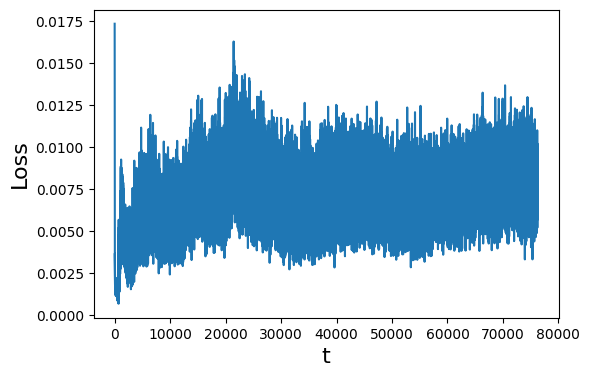

In [26]:
plt.figure(figsize=(6,4))
plt.plot(losses)
plt.xlabel("t",fontsize=16)
plt.ylabel("Loss",fontsize=16)

In [28]:
for s in range(n_s):
  print('s=',Q_main(get_in([s])).data.numpy())

s= [[0.18299809 0.16817984 0.17729183 0.16438383]]
s= [[0.13162129 0.12867554 0.08181451 0.1626972 ]]
s= [[0.16836818 0.15957382 0.16630524 0.16407122]]
s= [[0.09977762 0.11581007 0.08554985 0.15029599]]
s= [[0.20931226 0.12874213 0.1678599  0.12513429]]
s= [[0.32342023 0.3311603  0.28944373 0.24846768]]
s= [[0.18749413 0.08547423 0.20931894 0.04309542]]
s= [[0.2207647  0.1535464  0.22896215 0.18847543]]
s= [[0.14476547 0.1456478  0.2103329  0.27547312]]
s= [[0.19371475 0.37878844 0.27393883 0.20523164]]
s= [[0.41877037 0.2194589  0.3761792  0.2106489 ]]
s= [[0.21864654 0.1390151  0.18591994 0.14893515]]
s= [[0.25510818 0.27103135 0.29221055 0.19683659]]
s= [[0.17258187 0.49682945 0.5236083  0.3097444 ]]
s= [[0.5297482 0.7249148 0.7244127 0.5002974]]
s= [[0.18499386 0.14739788 0.2081678  0.21343903]]


In [29]:
pi_opt=np.zeros(n_s)
for s in range(n_s):
  if s not in [5,7,11,12,15]:
    pi_opt[s]=pi_eps(Q_main,s,eps=0)
pi_opt

array([0., 3., 0., 3., 0., 0., 2., 0., 3., 1., 0., 0., 0., 2., 1., 0.])

In [33]:
def test_agent(model,n_t=100,mode='human',display=True):
  env=gym.make('FrozenLake-v1',render_mode=mode)
  s,_=env.reset()
  for t in range(n_t):
    a=pi_eps(model,s,eps=0)
    s1,r,done,_,_=env.step(a)
    if display:
      print('t=',t,'s=',s,'r=',r,'s\=',s1,'done=',done)
      clear_output(wait=True)
    s=s1
    if done:
      if display:
        if r==1:
          print('YOU WON! Reward: %s' % (r))
        else:
          print('YOU LOST.')
      break
  if not done:
    if display:
      print('LOST: too many moves.')
  win=True if r==1 else False
  return win

In [34]:
n_t=100
test_agent(Q_main,n_t)

YOU WON! Reward: 1.0


True

In [37]:
n_game=1000
n_win=0
for i in range(n_game):
  win=test_agent(Q_main,mode=None,display=False)
  if win:
    n_win+=1
win_rate=n_win/n_game
print('Games play:{},# of wins:{}'.format(n_game,n_win))
print('Win Rate:{}%'.format(100*win_rate))

Games play:1000,# of wins:753
Win Rate:75.3%
